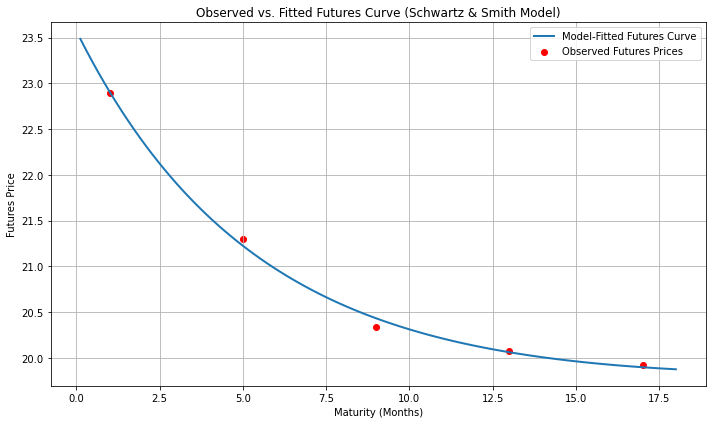

European Call Option Price (T=1Y, K=19.43): €0.3704


In [1]:
# ===============================
# 📦 Imports
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ===============================
# 📁 Step 1: Load & Clean Data
# ===============================
# Load dataset
df = pd.read_excel("Dataset_FuturesPrices.xlsx", sheet_name=0)

# Extract maturities (from row 0) and prices (from row 1)
valid_maturities = []
valid_prices = []

for label, price in zip(df.iloc[0, 0:5].values, df.iloc[1, 0:5].values):
    try:
        months = int(str(label).split()[0])
        price = float(price)
        valid_maturities.append(months / 12)  # convert to years
        valid_prices.append(price)
    except:
        continue

# Prepare data
maturities_months = np.array(valid_maturities)
futures_prices = np.array(valid_prices)
log_futures = np.log(futures_prices)

# ===============================
# 🧮 Step 2: Define Model Pricing Formula
# ===============================
def futures_log_price(T, X0, Y0, kappa, sigma_chi, sigma_xi, rho):
    term1 = Y0 + X0 * np.exp(-kappa * T)
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    variance = var_chi + var_xi + cov
    return term1 + 0.5 * variance

# ===============================
# 🔧 Step 3: Calibrate (X0, Y0, kappa)
# ===============================
def objective(params):
    X0, Y0, kappa = params
    sigma_chi = 0.1757
    sigma_xi = 0.1150
    rho = 0.0
    model_logs = np.array([
        futures_log_price(T, X0, Y0, kappa, sigma_chi, sigma_xi, rho)
        for T in maturities_months
    ])
    return np.sum((model_logs - log_futures) ** 2)

# Run optimization
initial_guess = [0.1, np.log(20), 1.0]
bounds = [(-1, 1), (0, 5), (0.1, 5)]
result = minimize(objective, initial_guess, bounds=bounds)
X0_est, Y0_est, kappa_est = result.x

# ===============================
# 📈 Step 4: Plot Fitted vs Observed Curve
# ===============================
T_grid = np.linspace(0.01, 1.5, 100)
sigma_chi = 0.1757
sigma_xi = 0.1150
rho = 0.0

fitted_prices = [
    np.exp(futures_log_price(T, X0_est, Y0_est, kappa_est, sigma_chi, sigma_xi, rho))
    for T in T_grid
]

plt.figure(figsize=(10, 6))
plt.plot(T_grid * 12, fitted_prices, label='Model-Fitted Futures Curve', lw=2)
plt.scatter(maturities_months * 12, futures_prices, color='red', label='Observed Futures Prices')
plt.xlabel('Maturity (Months)')
plt.ylabel('Futures Price')
plt.title('Observed vs. Fitted Futures Curve (Schwartz & Smith Model)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# 🔁 Step 5: Characteristic Function of ln S(T)
# ===============================
def char_func_lnST(u, T, X0, Y0, kappa, sigma_chi, sigma_xi, rho):
    mean = X0 * np.exp(-kappa * T) + Y0
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    variance = var_chi + var_xi + cov
    return np.exp(1j * u * mean - 0.5 * u**2 * variance)

# ===============================
# 💰 Step 6: COS Method for European Call on Futures
# ===============================
def cos_call_price(F0, K, r, T, char_func, N=128, L=10):
    c1 = np.log(F0)
    c2 = 0.2  # rough variance for integration range
    a = c1 - L * np.sqrt(c2)
    b = c1 + L * np.sqrt(c2)

    k = np.arange(N)
    u = k * np.pi / (b - a)

    def Chi(k, a, b, c, d):
        expr1 = np.cos(k * np.pi * (d - a) / (b - a)) * np.exp(d)
        expr2 = np.cos(k * np.pi * (c - a) / (b - a)) * np.exp(c)
        expr3 = k * np.pi / (b - a)
        return (expr1 - expr2) / (1 + expr3 ** 2)

    def Psi(k, a, b, c, d):
        expr = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a) / (b - a))
        result = np.zeros_like(k, dtype=float)
        result[1:] = (expr[1:] * (b - a)) / (k[1:] * np.pi)
        result[0] = d - c
        return result

    Vk = 2.0 / (b - a) * (Chi(k, a, b, np.log(K), b) - K * Psi(k, a, b, np.log(K), b))
    Vk[0] *= 0.5  # first term halved

    phi_vals = np.array([char_func(ui) for ui in u])
    payoff = np.real(phi_vals * np.exp(-1j * u * a) * Vk)

    return np.exp(-r * T) * np.sum(payoff)

# ===============================
# 💡 Step 7: Example Option Price
# ===============================
r = 0.05
T = 1.0  # 1 year maturity
K = np.exp(Y0_est)  # Strike = long-run futures price
F0 = np.exp(futures_log_price(T, X0_est, Y0_est, kappa_est, sigma_chi, sigma_xi, rho))
phi = lambda u: char_func_lnST(u, T, X0_est, Y0_est, kappa_est, sigma_chi, sigma_xi, rho)

call_price = cos_call_price(F0, K, r, T, phi)

print(f"European Call Option Price (T=1Y, K={K:.2f}): €{call_price:.4f}")


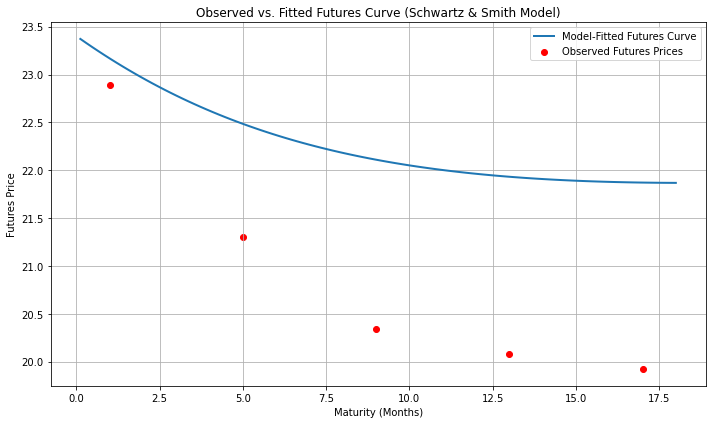

European Call Option Price (T=1Y, K ≈ 20.65): €3.8181


In [8]:
# ===============================
# 📦 Imports
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad

# ===============================
# 📁 Step 1: Load & Clean Data
# ===============================
df = pd.read_excel("Dataset_FuturesPrices.xlsx", sheet_name=0)

valid_maturities = []
valid_prices = []

for label, price in zip(df.iloc[0, 0:5].values, df.iloc[1, 0:5].values):
    try:
        months = int(str(label).split()[0])
        price = float(price)
        valid_maturities.append(months / 12)
        valid_prices.append(price)
    except:
        continue

maturities_months = np.array(valid_maturities)
futures_prices = np.array(valid_prices)
log_futures = np.log(futures_prices)

# ===============================
# 🔢 Step 2: Model Parameters from Kalman Filter
# ===============================
kappa = 1.7279
sigma_chi = 0.3246
sigma_xi = 0.1640
rho = 0.4494
mu_xi = -0.0038  # if needed
# lambda_chi = 0.1810  # ignored under Q

# These values should come from the Kalman filter output
#X0 = 0
#Y0 = 22.89
X0 = 0.125304
Y0 = 3.02749

# ===============================
# 📈 Step 3: Futures Log-Price Formula
# ===============================
def futures_log_price(T, X0, Y0, kappa, sigma_chi, sigma_xi, rho):
    term1 = Y0 + X0 * np.exp(-kappa * T)
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    return term1 + 0.5 * (var_chi + var_xi + cov)

# ===============================
# 📉 Step 4: Plot Fitted vs Observed Curve
# ===============================
T_grid = np.linspace(0.01, 1.5, 100)
fitted_prices = [
    np.exp(futures_log_price(T, X0, Y0, kappa, sigma_chi, sigma_xi, rho))
    for T in T_grid
]

plt.figure(figsize=(10, 6))
plt.plot(T_grid * 12, fitted_prices, label='Model-Fitted Futures Curve', lw=2)
plt.scatter(maturities_months * 12, futures_prices, color='red', label='Observed Futures Prices')
plt.xlabel('Maturity (Months)')
plt.ylabel('Futures Price')
plt.title('Observed vs. Fitted Futures Curve (Schwartz & Smith Model)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# 🧠 Step 5: Characteristic Function of ln S(T)
# ===============================
def char_func_lnST(u, T, X0, Y0, kappa, sigma_chi, sigma_xi, rho, mu_xi=0.0):
    mean = X0 * np.exp(-kappa * T) + Y0 + mu_xi * T
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    variance = var_chi + var_xi + cov
    return np.exp(1j * u * mean - 0.5 * u**2 * variance)

# ===============================
# 📈 Step 6: Compute π₁ and π₂ via Gauss-Legendre
# ===============================
T = 1.0
r = 0.05
K = np.exp(Y0)
S0 = np.exp(X0 + Y0)

φ = lambda u: char_func_lnST(u, T, X0, Y0, kappa, sigma_chi, sigma_xi, rho, mu_xi)

def integrand_pi1(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u - 1j)
    denominator = 1j * u * φ(-1j)
    return np.real(numerator / denominator)

def integrand_pi2(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u)
    denominator = 1j * u
    return np.real(numerator / denominator)

# Use Gauss-Legendre integration (200-point quadrature)
pi1_integral, _ = fixed_quad(integrand_pi1, 0, 100, n=200)
pi2_integral, _ = fixed_quad(integrand_pi2, 0, 100, n=200)

pi1 = 0.5 + (1 / np.pi) * pi1_integral
pi2 = 0.5 + (1 / np.pi) * pi2_integral

# ===============================
# 💰 Step 7: Compute Call Option Price
# ===============================
call_price = np.exp(-r * T) * (S0 * pi1 - K * pi2)
print(f"European Call Option Price (T=1Y, K ≈ {K:.2f}): €{call_price:.4f}")


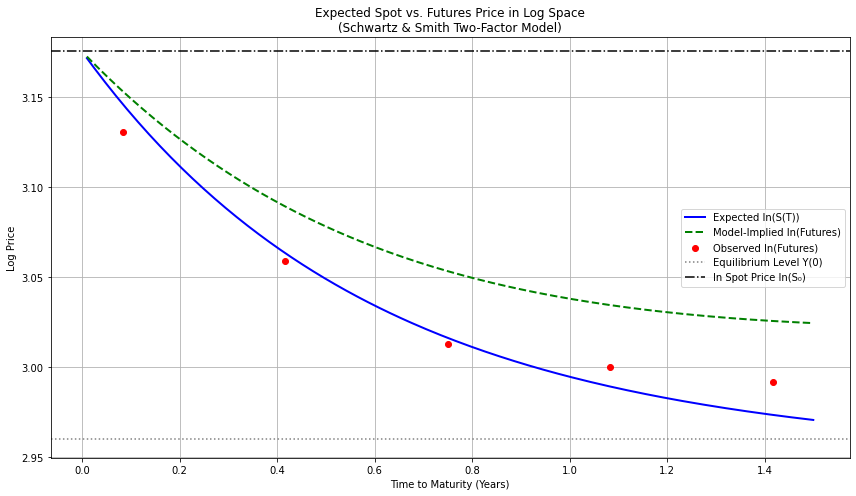

In [20]:
# ===============================
# 📦 Imports
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 📁 Load Dataset
# ===============================
df = pd.read_excel("Dataset_FuturesPrices.xlsx")

# Use columns A–E for prices, G–K for log-prices
maturities_labels = df.iloc[0, 0:5].values
observed_prices = df.iloc[1, 0:5].astype(float).values
log_observed_prices = df.iloc[1, 6:11].astype(float).values

# Convert maturity labels to years
maturities_years = np.array([int(label.split()[0]) / 12 for label in maturities_labels])

# ===============================
# 🔢 Model Parameters (from Kalman)
# ===============================
kappa = 1.7279
sigma_chi = 0.3246
sigma_xi = 0.1640
rho = 0.4494
mu_xi = -0.0038
X0 = 0.215304
Y0 = 2.96002749
S0 = np.exp(X0 + Y0)
ln_S0 = np.log(S0)

# ===============================
# 🧮 Theoretical Formulas
# ===============================
def expected_log_spot_price(T, X0, Y0, kappa, mu_xi):
    return X0 * np.exp(-kappa * T) + Y0 + mu_xi * T

def futures_log_price(T, X0, Y0, kappa, sigma_chi, sigma_xi, rho):
    term1 = Y0 + X0 * np.exp(-kappa * T)
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    return term1 + 0.5 * (var_chi + var_xi + cov)

# ===============================
# 📈 Plot: Expected ln S(T) vs ln F(0,T)
# ===============================
T_grid = np.linspace(0.01, 1.5, 200)
expected_lnS = expected_log_spot_price(T_grid, X0, Y0, kappa, mu_xi)
model_lnF = futures_log_price(T_grid, X0, Y0, kappa, sigma_chi, sigma_xi, rho)

plt.figure(figsize=(12, 7))
plt.plot(T_grid, expected_lnS, label="Expected ln(S(T))", color='blue', lw=2)
plt.plot(T_grid, model_lnF, label="Model-Implied ln(Futures)", color='green', lw=2, linestyle='--')
plt.scatter(maturities_years, log_observed_prices, color='red', label="Observed ln(Futures)", zorder=5)
plt.axhline(Y0, color='gray', linestyle=':', label='Equilibrium Level Y(0)')
plt.axhline(ln_S0, color='black', linestyle='-.', label='ln Spot Price ln(S₀)')

plt.title("Expected Spot vs. Futures Price in Log Space\n(Schwartz & Smith Two-Factor Model)")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Log Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


European Call Option Price (T=1Y, K ≈ 19.30): €4.6606


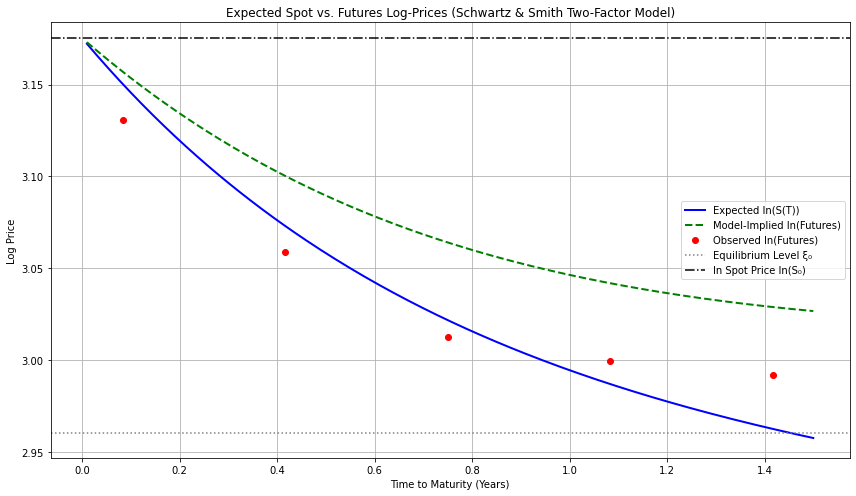

In [22]:
# ===============================
# 📦 Imports
# ===============================
import numpy as np
import pandas as pd
from scipy.integrate import fixed_quad
import matplotlib.pyplot as plt

# ===============================
# 📁 Load Dataset
# ===============================
df = pd.read_excel("Dataset_FuturesPrices.xlsx")

# Columns A–E: prices | G–K: log-prices
maturities_labels = df.iloc[0, 0:5].values
observed_prices = df.iloc[1, 0:5].astype(float).values
log_observed_prices = df.iloc[1, 6:11].astype(float).values
maturities_years = np.array([int(label.split()[0]) / 12 for label in maturities_labels])

# ===============================
# 🔢 Model Parameters (from Kalman filter)
# ===============================
kappa = 1.3784
sigma_chi = 0.2894
sigma_xi = 0.1476
rho = 0.3
mu_xi = -0.0198
chi_0 = 0.215304
xi_0 = 2.96002749
S0 = np.exp(chi_0 + xi_0)
ln_S0 = np.log(S0)

# ===============================
# 🧠 Characteristic Function of ln(S(T))
# ===============================
def char_func_lnST(u, T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_xi=0.0):
    mean = chi_0 * np.exp(-kappa * T) + xi_0 + mu_xi * T
    var_chi = (sigma_chi**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = (2 * rho * sigma_chi * sigma_xi / kappa) * (1 - np.exp(-kappa * T))
    variance = var_chi + var_xi + cov
    return np.exp(1j * u * mean - 0.5 * u**2 * variance)

# ===============================
# ∫ Gauss-Legendre for π₁ and π₂
# ===============================
T = 1.0
r = 0.05
K = np.exp(xi_0)

φ = lambda u: char_func_lnST(u, T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_xi)

def integrand_pi1(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u - 1j)
    denominator = 1j * u * φ(-1j)
    return np.real(numerator / denominator)

def integrand_pi2(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u)
    denominator = 1j * u
    return np.real(numerator / denominator)

pi1_integral, _ = fixed_quad(integrand_pi1, 0, 100, n=200)
pi2_integral, _ = fixed_quad(integrand_pi2, 0, 100, n=200)

pi1 = 0.5 + (1 / np.pi) * pi1_integral
pi2 = 0.5 + (1 / np.pi) * pi2_integral

# ===============================
# 💰 European Call Option Price
# ===============================
call_price = np.exp(-r * T) * (S0 * pi1 - K * pi2)
print(f"European Call Option Price (T=1Y, K ≈ {K:.2f}): €{call_price:.4f}")

# ===============================
# 📈 Expected Spot vs. Futures Log-Prices
# ===============================
def expected_log_spot_price(T, chi_0, xi_0, kappa, mu_xi):
    return chi_0 * np.exp(-kappa * T) + xi_0 + mu_xi * T

def futures_log_price(T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho):
    term1 = xi_0 + chi_0 * np.exp(-kappa * T)
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    return term1 + 0.5 * (var_chi + var_xi + cov)

T_grid = np.linspace(0.01, 1.5, 200)
expected_lnS = expected_log_spot_price(T_grid, chi_0, xi_0, kappa, mu_xi)
model_lnF = futures_log_price(T_grid, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho)

# Time grid
T_grid = np.linspace(0.01, 1.5, 200)
expected_lnS = expected_log_spot_price(T_grid, chi_0, xi_0, kappa, mu_xi)
model_lnF = futures_log_price(T_grid, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho)
ln_S0 = chi_0 + xi_0

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(T_grid, expected_lnS, label="Expected ln(S(T))", color='blue', lw=2)
plt.plot(T_grid, model_lnF, label="Model-Implied ln(Futures)", color='green', lw=2, linestyle='--')
plt.scatter(maturities_years, log_observed_prices, color='red', label="Observed ln(Futures)", zorder=5)
plt.axhline(xi_0, color='gray', linestyle=':', label='Equilibrium Level ξ₀')
plt.axhline(ln_S0, color='black', linestyle='-.', label='ln Spot Price ln(S₀)')

plt.title("Expected Spot vs. Futures Log-Prices (Schwartz & Smith Two-Factor Model)")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Log Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


European Call Option Price (T=1Y, K ≈ 19.30): €4.6606


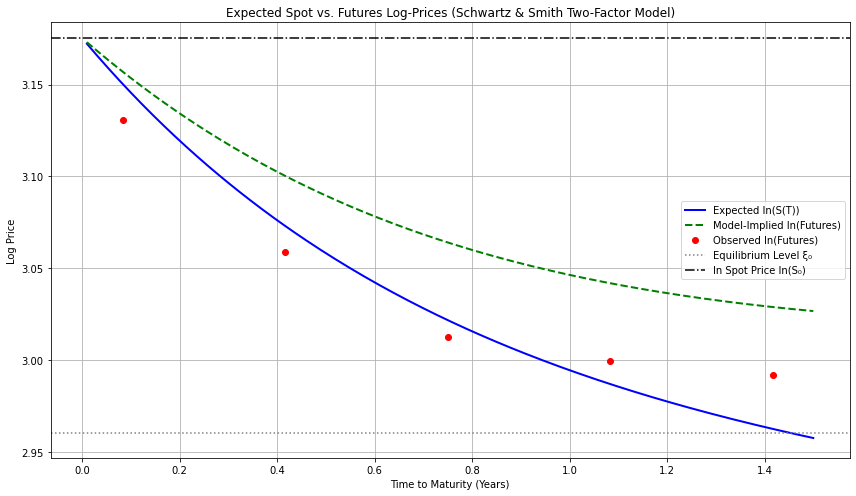

In [30]:
# Imports
import numpy as np
import pandas as pd
from scipy.integrate import fixed_quad
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_excel("Dataset_FuturesPrices.xlsx")

# Columns A–E: prices | G–K: log-prices
maturities_labels = df.iloc[0, 0:5].values
observed_prices = df.iloc[1, 0:5].astype(float).values
log_observed_prices = df.iloc[1, 6:11].astype(float).values
maturities_years = np.array([int(label.split()[0]) / 12 for label in maturities_labels])

# Model Parameters (from Kalman filter)
kappa = 1.3784
sigma_chi = 0.2894
sigma_xi = 0.1476
rho = 0.3
mu_xi = -0.0198
chi_0 = 0.215304
xi_0 = 2.96002749
S0 = np.exp(chi_0 + xi_0)
ln_S0 = np.log(S0)

# Characteristic Function of ln(S(T))
def char_func_lnST(u, T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_xi=0.0):
    mean = chi_0 * np.exp(-kappa * T) + xi_0 + mu_xi * T
    var_chi = (sigma_chi**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = (2 * rho * sigma_chi * sigma_xi / kappa) * (1 - np.exp(-kappa * T))
    variance = var_chi + var_xi + cov
    return np.exp(1j * u * mean - 0.5 * u**2 * variance)

# ∫ Gauss-Legendre for π₁ and π₂
T = 1.0
r = 0.05
K = np.exp(xi_0)

φ = lambda u: char_func_lnST(u, T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_xi)

def integrand_pi1(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u - 1j)
    denominator = 1j * u * φ(-1j)
    return np.real(numerator / denominator)

def integrand_pi2(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u)
    denominator = 1j * u
    return np.real(numerator / denominator)

pi1_integral, _ = fixed_quad(integrand_pi1, 0, 20, n=32)
pi2_integral, _ = fixed_quad(integrand_pi2, 0, 20, n=32)

pi1 = 0.5 + (1 / np.pi) * pi1_integral
pi2 = 0.5 + (1 / np.pi) * pi2_integral

# European Call Option Price
call_price = np.exp(-r * T) * (S0 * pi1 - K * pi2)
print(f"European Call Option Price (T=1Y, K ≈ {K:.2f}): €{call_price:.4f}")

# Convergence Test
#upper_bounds = [20, 40, 60, 80, 100, 200]
#quadrature_points = [32, 64, 128, 200]

#results = []

#for bound in upper_bounds:
#    for n in quadrature_points:
#        pi1_integral, _ = fixed_quad(integrand_pi1, 0, bound, n=n)
#        pi2_integral, _ = fixed_quad(integrand_pi2, 0, bound, n=n)
#        pi1 = 0.5 + (1 / np.pi) * pi1_integral
#        pi2 = 0.5 + (1 / np.pi) * pi2_integral
#        call_price = np.exp(-r * T) * (S0 * pi1 - K * pi2)
#        results.append({
#            'Upper Bound (U)': bound,
#            'Quadrature Points (n)': n,
#            'Call Option Price (€)': round(call_price, 6)
#        })

# Results display
#df_results = pd.DataFrame(results)
#print(df_results)


# Expected Spot vs. Futures Log-Prices
def expected_log_spot_price(T, chi_0, xi_0, kappa, mu_xi):
    return chi_0 * np.exp(-kappa * T) + xi_0 + mu_xi * T

def futures_log_price(T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho):
    term1 = xi_0 + chi_0 * np.exp(-kappa * T)
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    return term1 + 0.5 * (var_chi + var_xi + cov)

T_grid = np.linspace(0.01, 1.5, 200)
expected_lnS = expected_log_spot_price(T_grid, chi_0, xi_0, kappa, mu_xi)
model_lnF = futures_log_price(T_grid, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho)

# Time grid
T_grid = np.linspace(0.01, 1.5, 200)
expected_lnS = expected_log_spot_price(T_grid, chi_0, xi_0, kappa, mu_xi)
model_lnF = futures_log_price(T_grid, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho)
ln_S0 = chi_0 + xi_0

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(T_grid, expected_lnS, label="Expected ln(S(T))", color='blue', lw=2)
plt.plot(T_grid, model_lnF, label="Model-Implied ln(Futures)", color='green', lw=2, linestyle='--')
plt.scatter(maturities_years, log_observed_prices, color='red', label="Observed ln(Futures)", zorder=5)
plt.axhline(xi_0, color='gray', linestyle=':', label='Equilibrium Level ξ₀')
plt.axhline(ln_S0, color='black', linestyle='-.', label='ln Spot Price ln(S₀)')

plt.title("Expected Spot vs. Futures Log-Prices (Schwartz & Smith Two-Factor Model)")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Log Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
